# Topo Everywhere

## Intro
* **Date**: 1/14/2021
* **What**: Same architecture as the last experiment, but I'm also adding topology to the invariant layer as well.
* **Why**: Because it makes things infinitely easier to see and understand.  And, I imagine, it also probably helps the network figure out what's going on as well.
* **Hopes**: I'm a little nervous how the lateral excitation in the invariant layer is going to play with the intermittent normalization.  We'll see, I suppose.
* **Limitations**: Aside from nicely organizing everything, which makes understanding what's happening in the network significantly easier, I'm not sure if topological organization is actually doing all that much.  But as the developer, what's good for me is good for the network, so full steam ahead!!

## Code

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

(x_tr, _), _ = mnist.load_data()

x_tr = x_tr / 255.0

In [2]:
t_sl = 30 # Tapestry side length
m_sl = 28 # Side length of each images

tapestry = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 0

for x in range(t_sl):
    for y in range(t_sl):

        tapestry[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tapestry[(t_sl - 1) * m_sl:, :] = tapestry[: m_sl, :]
tapestry[:, (t_sl - 1) * m_sl:] = tapestry[:, : m_sl]

<IPython.core.display.Javascript object>


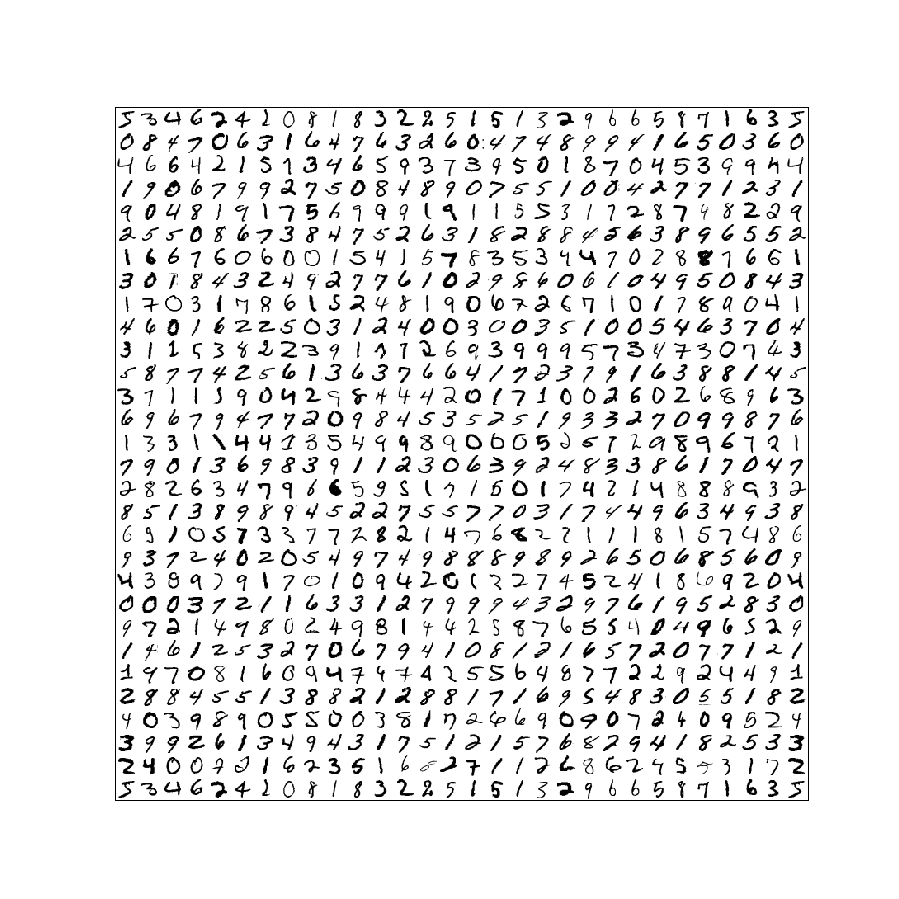

In [3]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(tapestry, cmap="gray_r")

In [4]:
x_o = 420
y_o = 420

sl = 20

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 10_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])

<IPython.core.display.Javascript object>


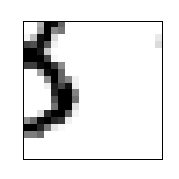

In [5]:
%matplotlib notebook
fig = plt.figure(figsize=(2, 2))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

In [6]:
img_array = np.array(imgs)
ts_data = img_array.reshape(-1, sl ** 2)
gp_data = cp.asarray(ts_data)

In [7]:
def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

In [11]:
def gen_lat_ex(Kx, Ky, ex, coeff):

    lat_ex = []

    for y in range(Ky):
        for x in range(Kx):
            curr_ex = np.zeros((Ky, Kx))
            curr_ex[max(0, y - ex): min(Ky, y + ex + 1), max(0, x - ex): min(Kx, x + ex + 1)] = 1

            if y - ex < 0:
                curr_ex[y - ex:, max(0, x - ex): min(Kx, x + ex + 1)] = 1
            if y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, max(0, x - ex): min(Kx, x + ex + 1)] = 1

            if x - ex < 0:
                curr_ex[max(0, y - ex): min(Ky, y + ex + 1), x - ex:] = 1
            if x + ex + 1 > Kx:
                curr_ex[max(0, y - ex): min(Ky, y + ex + 1), :x + ex + 1 - Kx] = 1

            if y - ex < 0 and x - ex < 0:
                curr_ex[y - ex:, x - ex:] = 1

            if x + ex + 1 > Kx and y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, :x + ex + 1 - Kx] = 1

            if y - ex < 0 and x + ex + 1 > Kx:
                curr_ex[y - ex:, :x + ex + 1 - Kx] = 1


            if x - ex < 0 and y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, x - ex:] = 1

            lat_ex.append(curr_ex.reshape(-1))

    lat_ex = cp.array(lat_ex)
    np.fill_diagonal(lat_ex, 0)

    lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * coeff
    np.fill_diagonal(lat_ex, 1)
    
    return lat_ex

## Analysis Dialog

Well, this is going to be simply fascinating.

<IPython.core.display.Javascript object>


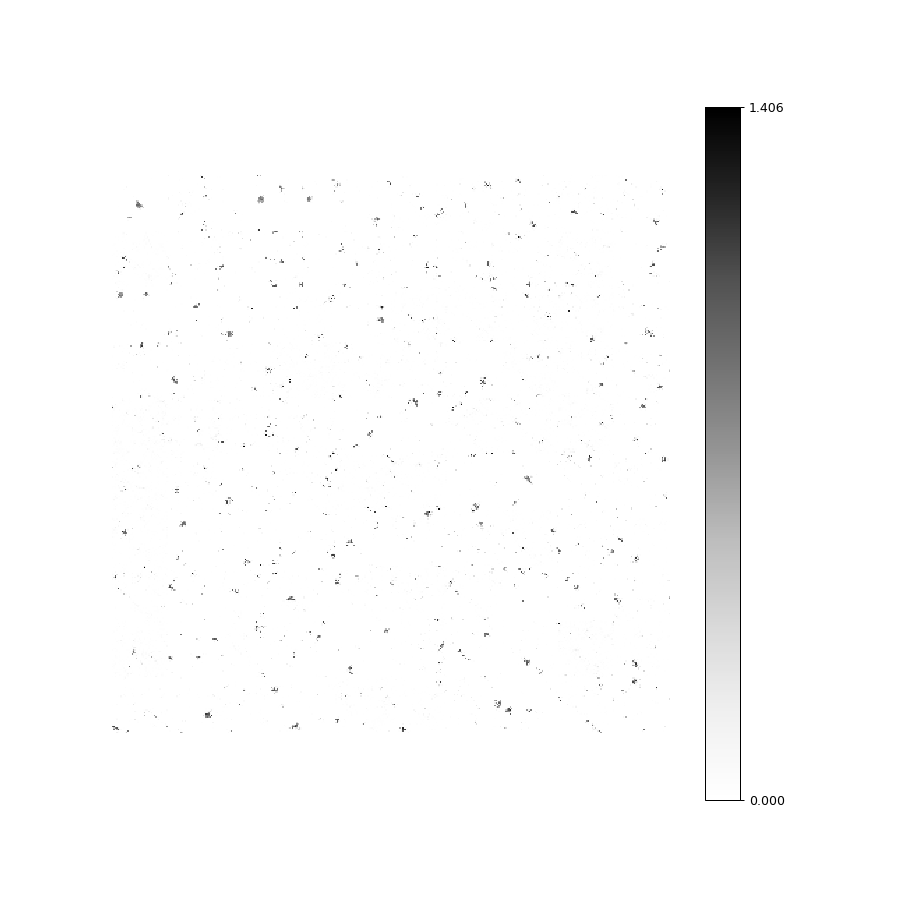

100%|██████████| 10000/10000 [00:10<00:00, 968.95it/s]


In [14]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 40
Ky = 40
sN = Kx * Ky
m_len = sl ** 2
sex = 2
sex_coeff = 0.5

s_lat_ex = gen_lat_ex(Kx, Ky, sex, sex_coeff)

n_w = 4 #Number of winners


sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.02

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy
iex = 2
iex_coeff = 0.1

i_lat_ex = gen_lat_ex(Ix, Iy, iex, iex_coeff)

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 2 / 6
leta = 0.08
seta = 0.0008

i_norm = sN / iN

for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        io_pert = i_lat_ex @ io_pert # Lat ex
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = i_norm * (iw / cp.sum(iw, axis=1).reshape(-1, 1))

    if (ep // 4) % 2 == 0:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


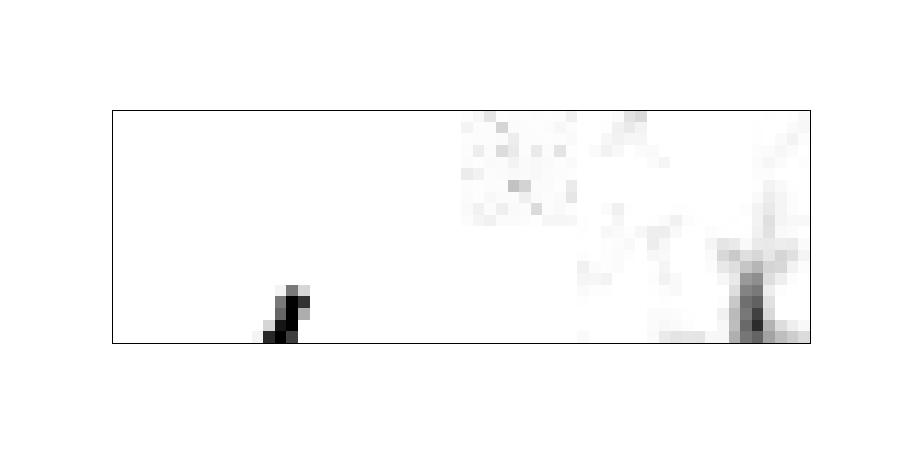

100%|██████████| 500/500 [00:01<00:00, 354.67it/s]


In [17]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()
lx_np = s_lat_ex.get()
ix_np = i_lat_ex.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    c = lx_np @ p
    winners = np.argsort(c, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_pert = iw_np @ so
    io_pert = ix_np @ io_pert # Lat ex
    
    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((20, 60))
    
    glee = 10
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io.reshape(glee, glee)
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Eh, that topology doesn't seem to be super strong.  I'm going to increase `iex_coeff`.

<IPython.core.display.Javascript object>


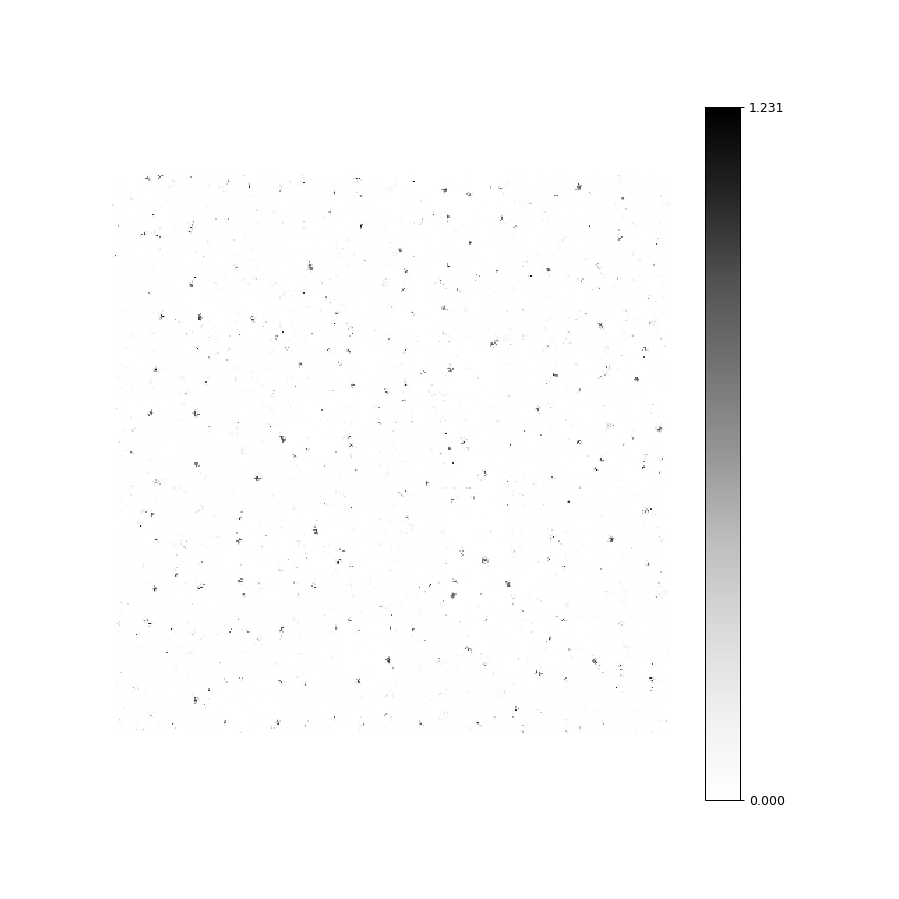

100%|██████████| 10000/10000 [00:10<00:00, 975.64it/s]


In [18]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 40
Ky = 40
sN = Kx * Ky
m_len = sl ** 2
sex = 2
sex_coeff = 0.5

s_lat_ex = gen_lat_ex(Kx, Ky, sex, sex_coeff)

n_w = 4 #Number of winners


sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.02

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy
iex = 2
iex_coeff = 0.3

i_lat_ex = gen_lat_ex(Ix, Iy, iex, iex_coeff)

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 2 / 6
leta = 0.08
seta = 0.0008

i_norm = sN / iN

for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        io_pert = i_lat_ex @ io_pert # Lat ex
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = i_norm * (iw / cp.sum(iw, axis=1).reshape(-1, 1))

    if (ep // 4) % 2 == 0:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)

Wow I should really keep the sparse layer.  That'd save me some training time for sure.

<IPython.core.display.Javascript object>


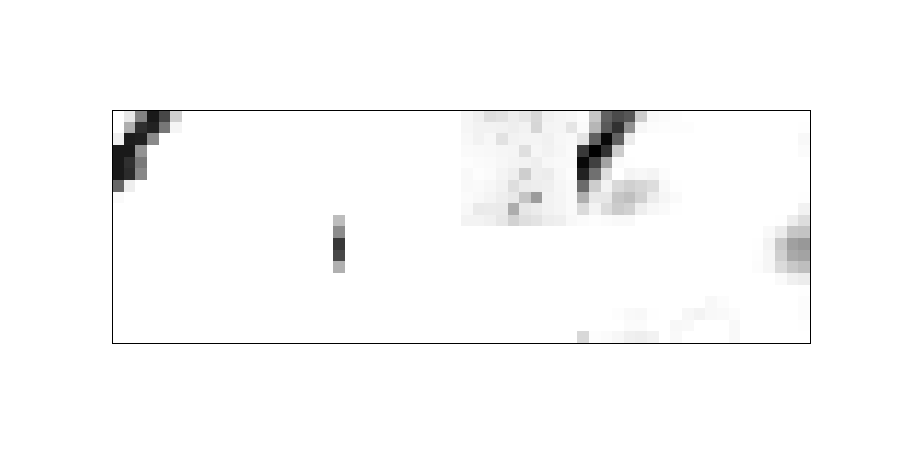

100%|██████████| 500/500 [00:01<00:00, 349.32it/s]


In [19]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()
lx_np = s_lat_ex.get()
ix_np = i_lat_ex.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    c = lx_np @ p
    winners = np.argsort(c, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_pert = iw_np @ so
    io_pert = ix_np @ io_pert # Lat ex
    
    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((20, 60))
    
    glee = 10
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io.reshape(glee, glee)
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Wow, in that one, you can actually see the "topology blooms," I'll call them.  Those blooms would be problematic, however, if I'm detecting change in the input state via increases in activity.  Yeah, I don't think I actually really want lat ex in the invariant layer.  Hmm.  Unless I constrained `io_pert` to only have five winners at a time. Actually, here's probably one of the better ways to see if there's actually any topology at all in the invariant layer.

<IPython.core.display.Javascript object>


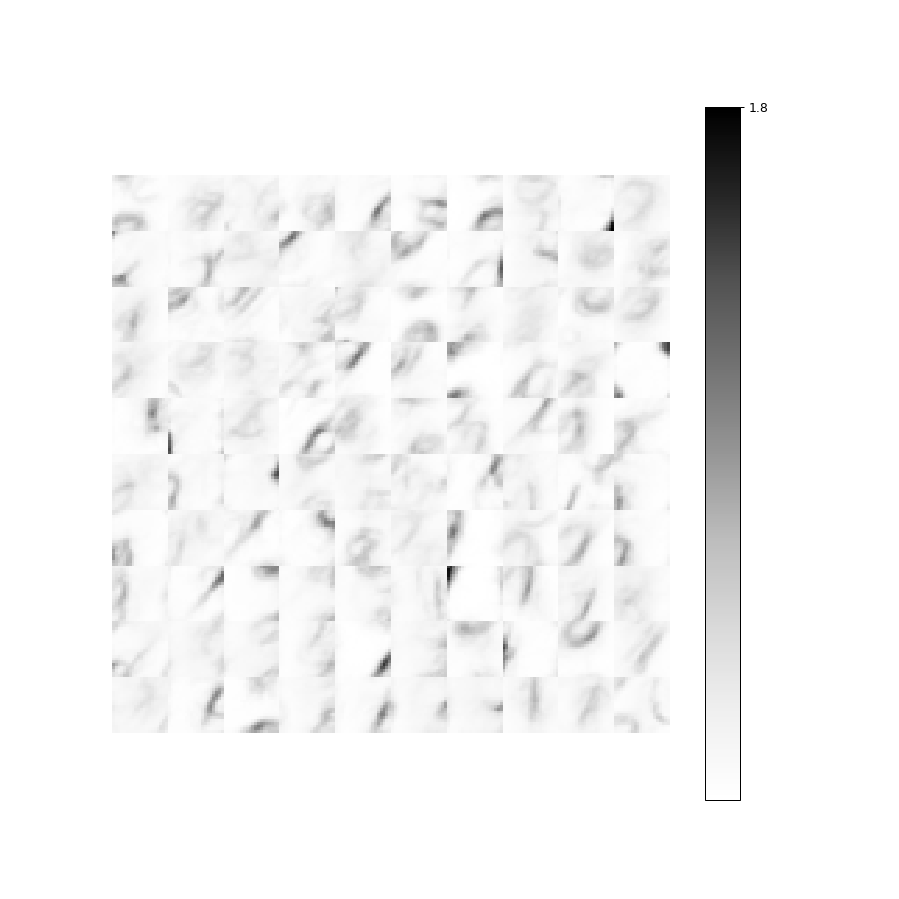

In [20]:
fig = plt.figure(figsize=(10, 10))

draw_weights((iw @ sw).get(), Ix, Iy, 20, fig)

Yeah, I think it looks decently organized.  I'm going to increase `iex_coeff` to 0.5 and see what happens.  I think it mostly turns out that even though the invariant prototypes look alarmingly similar in the beginning, they settle on different prototypes.

I'm also *not* going to reinitialize the sparse layer because I'm making a desperate effort to not be stupid.

<IPython.core.display.Javascript object>


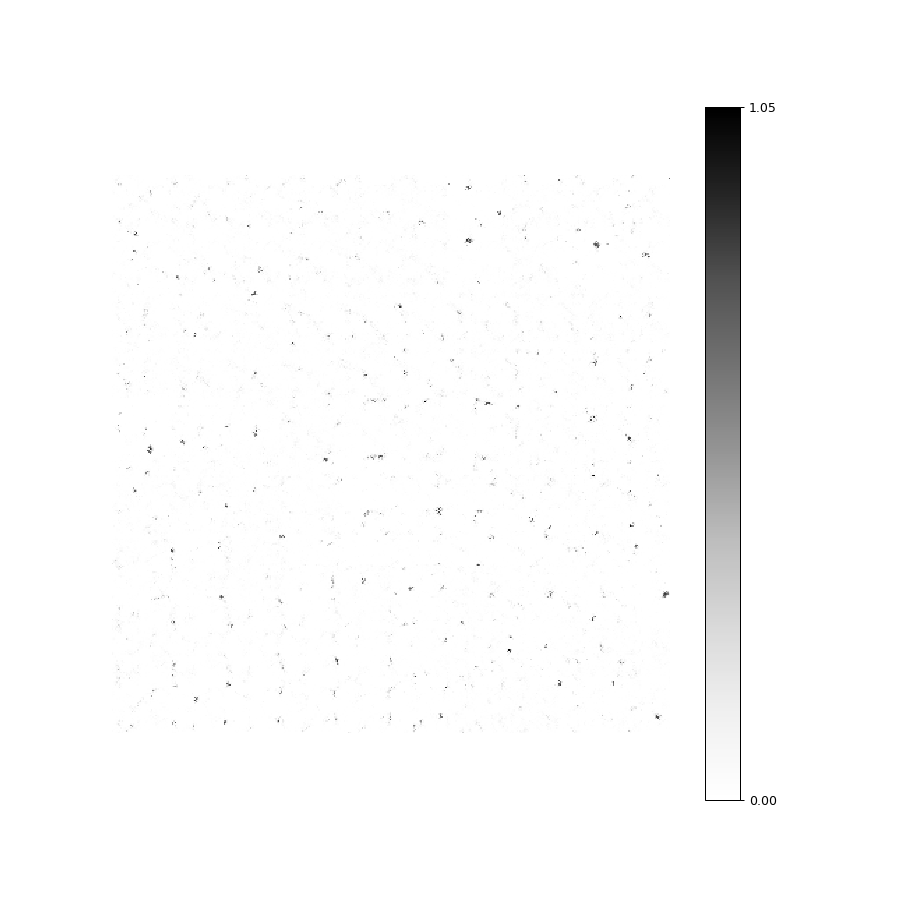

100%|██████████| 10000/10000 [00:10<00:00, 925.22it/s]


In [21]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10


# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy
iex = 2
iex_coeff = 0.5

i_lat_ex = gen_lat_ex(Ix, Iy, iex, iex_coeff)

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 2 / 6
leta = 0.08
seta = 0.0008

i_norm = sN / iN

for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        io_pert = i_lat_ex @ io_pert # Lat ex
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = i_norm * (iw / cp.sum(iw, axis=1).reshape(-1, 1))

    if (ep // 4) % 2 == 0:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)

I think it could use some more training.

<IPython.core.display.Javascript object>


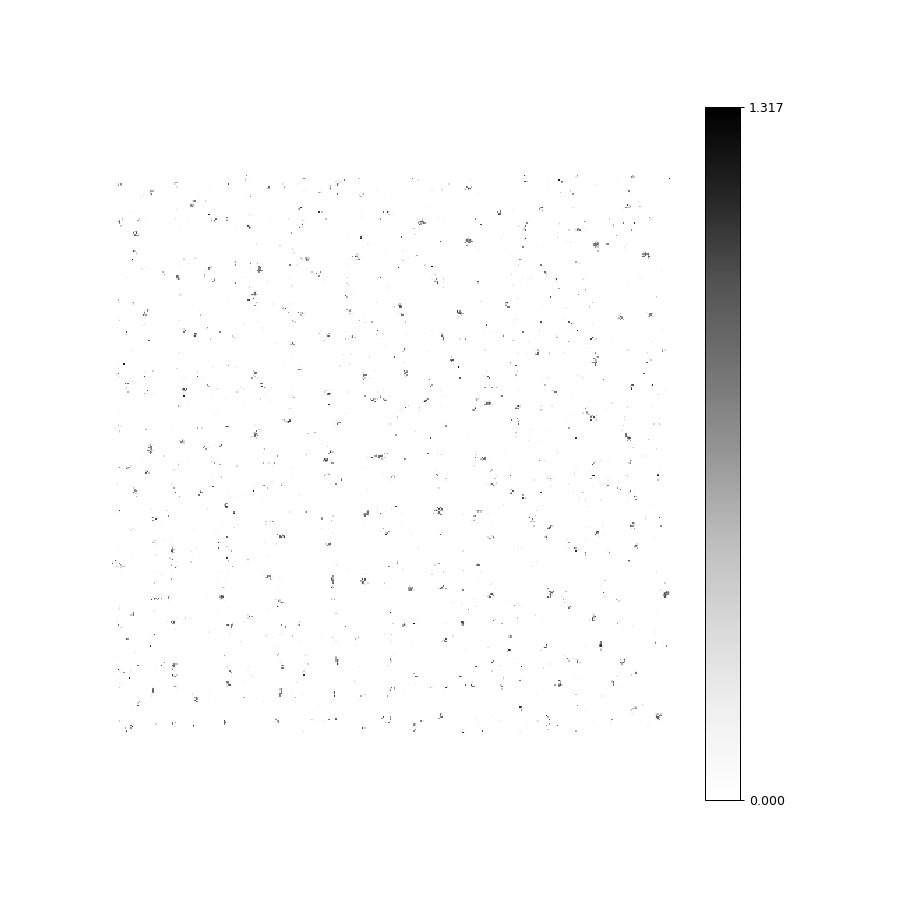

100%|██████████| 10000/10000 [00:10<00:00, 924.39it/s]


In [22]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

i_norm = sN / iN

for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        io_pert = i_lat_ex @ io_pert # Lat ex
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = i_norm * (iw / cp.sum(iw, axis=1).reshape(-1, 1))

    if (ep // 4) % 2 == 0:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)

Dang.  This time round, you can even see the topology in the invariant prototypes.  Ok, I'm going to plot animation, overlapping features, and the sparse coverage map.

<IPython.core.display.Javascript object>


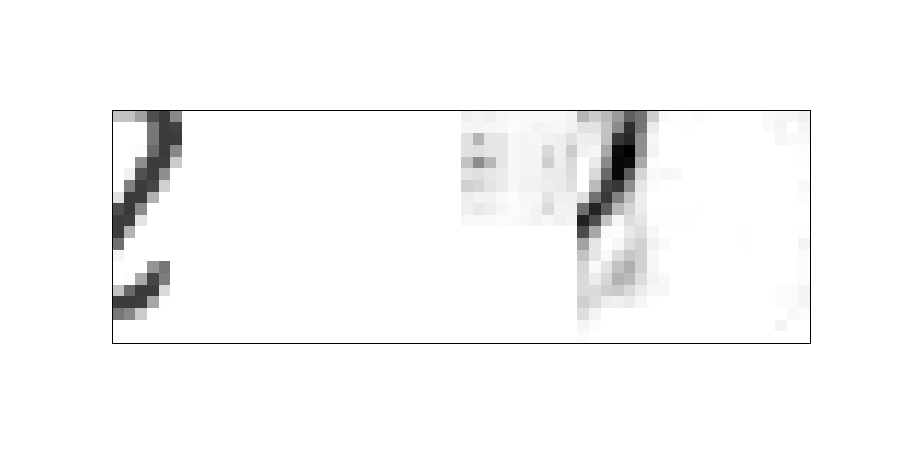

100%|██████████| 500/500 [00:01<00:00, 347.01it/s]


In [23]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()
lx_np = s_lat_ex.get()
ix_np = i_lat_ex.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    c = lx_np @ p
    winners = np.argsort(c, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_pert = iw_np @ so
    io_pert = ix_np @ io_pert # Lat ex
    
    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((20, 60))
    
    glee = 10
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io.reshape(glee, glee)
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


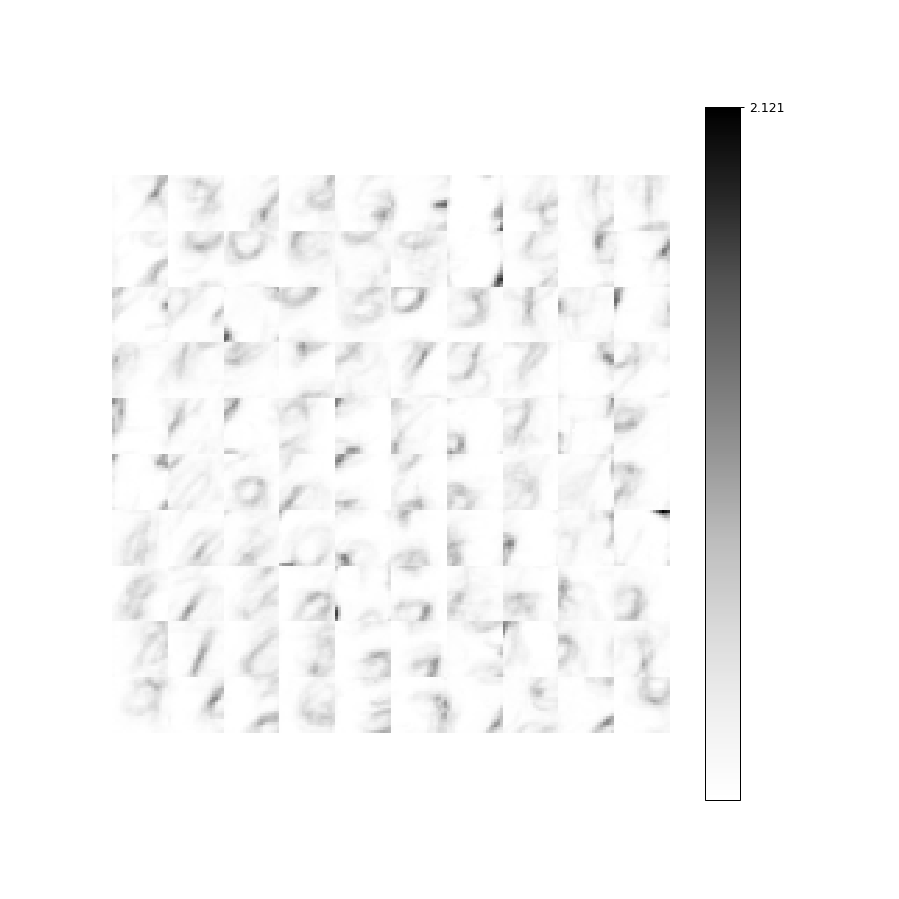

In [24]:
fig = plt.figure(figsize=(10, 10))

draw_weights((iw @ sw).get(), Ix, Iy, 20, fig)

Ah ha.  That is quite well-organized, if I do say so myself.  Ok, let's see the coverage map.

<IPython.core.display.Javascript object>


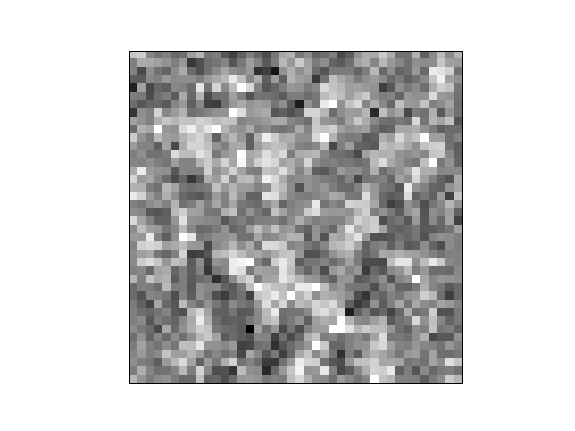

In [25]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(cp.sum(iw, axis=0).reshape(Kx, Ky).get(), cmap="gray_r")

<IPython.core.display.Javascript object>


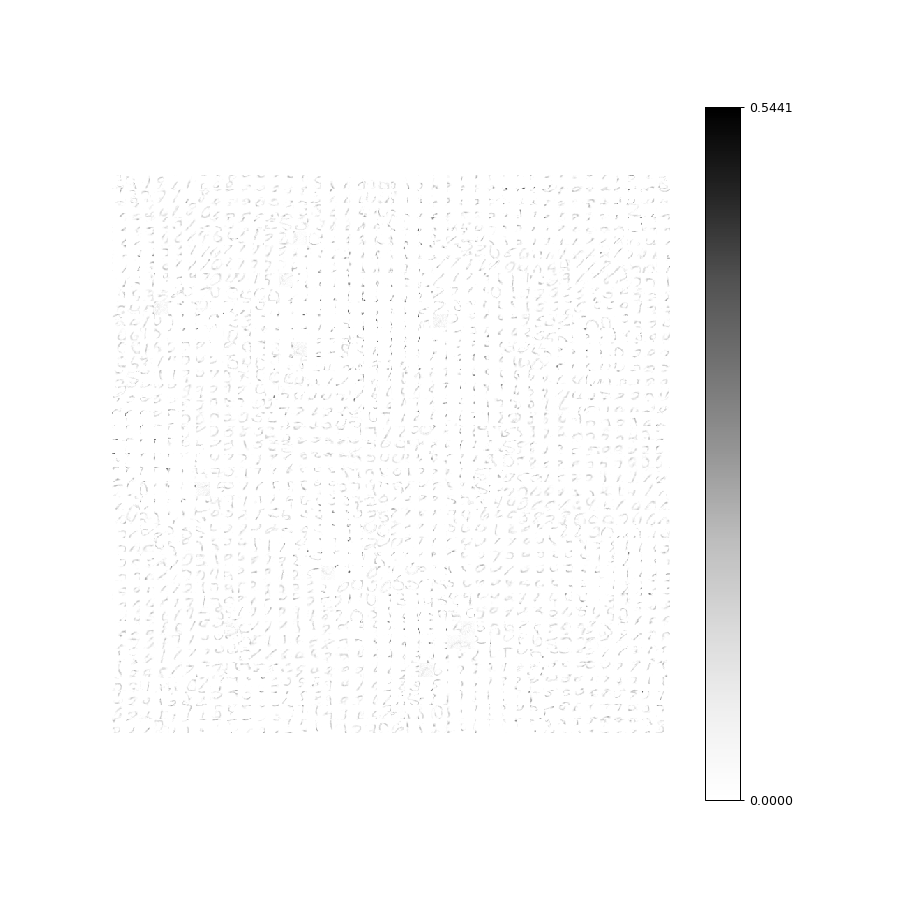

In [26]:
fig = plt.figure(figsize=(10, 10))
draw_weights(sw.get(), Kx, Ky, sl, fig)

I'm actually pretty happy with that coverage.  

Let's check out max and min features.

<IPython.core.display.Javascript object>


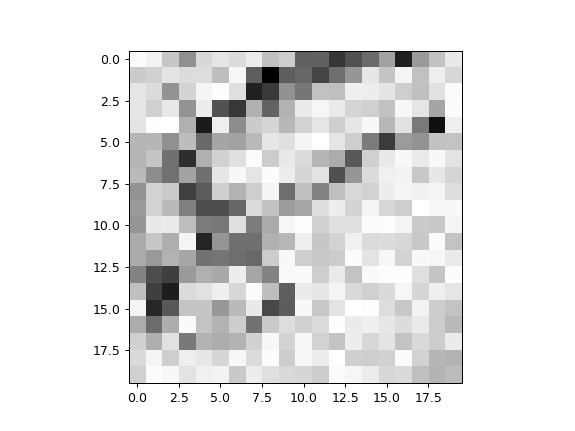

6.254697775844208e-10
292


In [27]:
plt.figure()
print(np.min(cp.sum(iw, axis=0).reshape(Kx, Ky).get()))
print(np.argmin(cp.sum(iw, axis=0).reshape(Kx, Ky).get()))
plt.imshow(sw.get()[np.argmin(cp.sum(iw, axis=0).reshape(Kx, Ky).get())].reshape(20, 20), cmap='gray_r')

Yeah that straight-up sucks.  I think that's one on the far-right middle edge.  Yeah that prototype sucks.

<IPython.core.display.Javascript object>


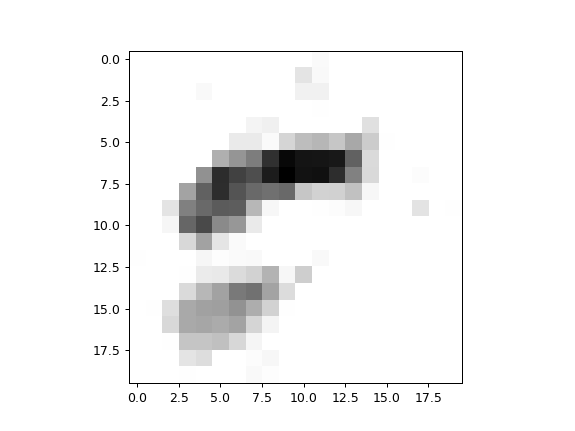

1334
2.053912239247844


In [29]:
plt.figure()
print(np.argmax(cp.sum(iw, axis=0).reshape(Kx, Ky).get()))
print(np.max(cp.sum(iw, axis=0).reshape(Kx, Ky).get()))
plt.imshow(sw.get()[np.argmax(cp.sum(iw, axis=0).reshape(Kx, Ky).get())].reshape(20, 20), cmap='gray_r')

Interesting.  You know what?  I don't actually think the max is the strongest term, I think it just happens to be covered twice.  Well, I guess the different coverages could be different.  Anyway, that actually doesn't say much.  

Ok, before I wrap up this experiment, there's one more thing I gotta try.  I'm going to only allow `io_pert` the same number of winners as the sparse layer, see what happens then.

I'm training with the same sparse layer, of course.  Hey guess what the idiot nerds call that?  Transfer learning!  Haha.

<IPython.core.display.Javascript object>


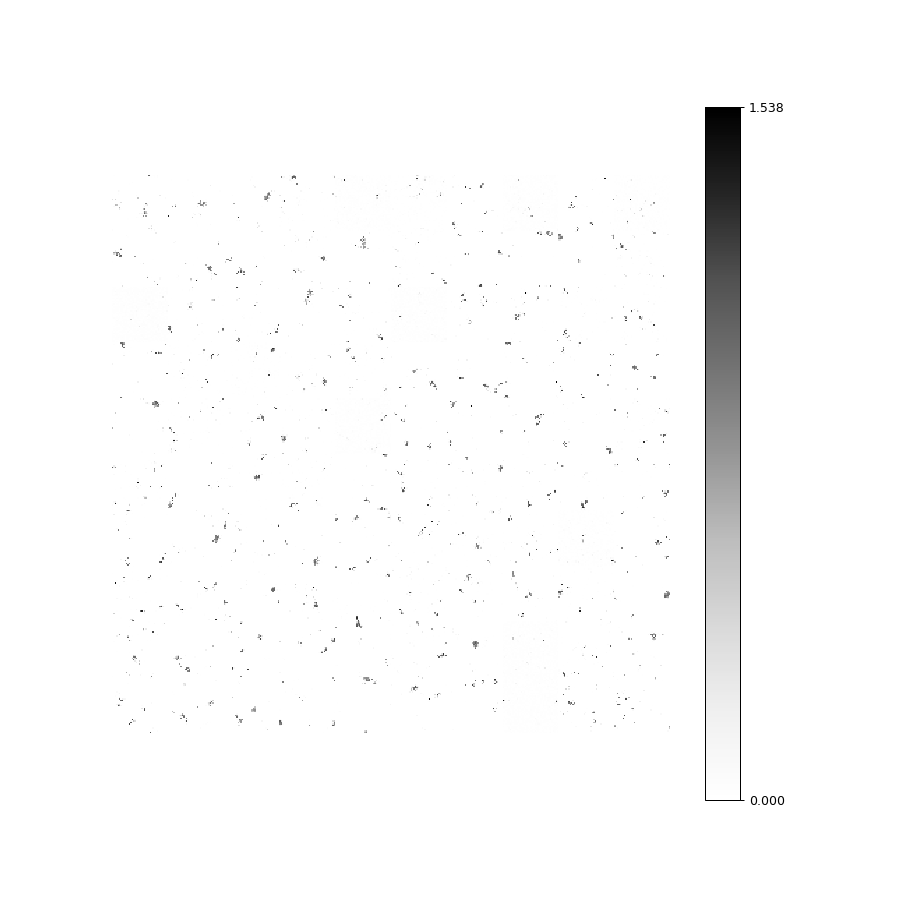

100%|██████████| 10000/10000 [00:13<00:00, 767.24it/s]


In [30]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10


# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy
iex = 2
iex_coeff = 0.5

i_lat_ex = gen_lat_ex(Ix, Iy, iex, iex_coeff)

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 2 / 6
leta = 0.08
seta = 0.0008

i_norm = sN / iN

for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_i = iw @ so
        io_i = i_lat_ex @ io_i # Lat ex
        
        winners = cp.argsort(io_i, axis=0)[-n_w:]
        mask = cp.zeros((iN, 1))
        mask[winners] = 1
        
        io_pert = mask * io_i
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = i_norm * (iw / cp.sum(iw, axis=1).reshape(-1, 1))

    if (ep // 4) % 2 == 0:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


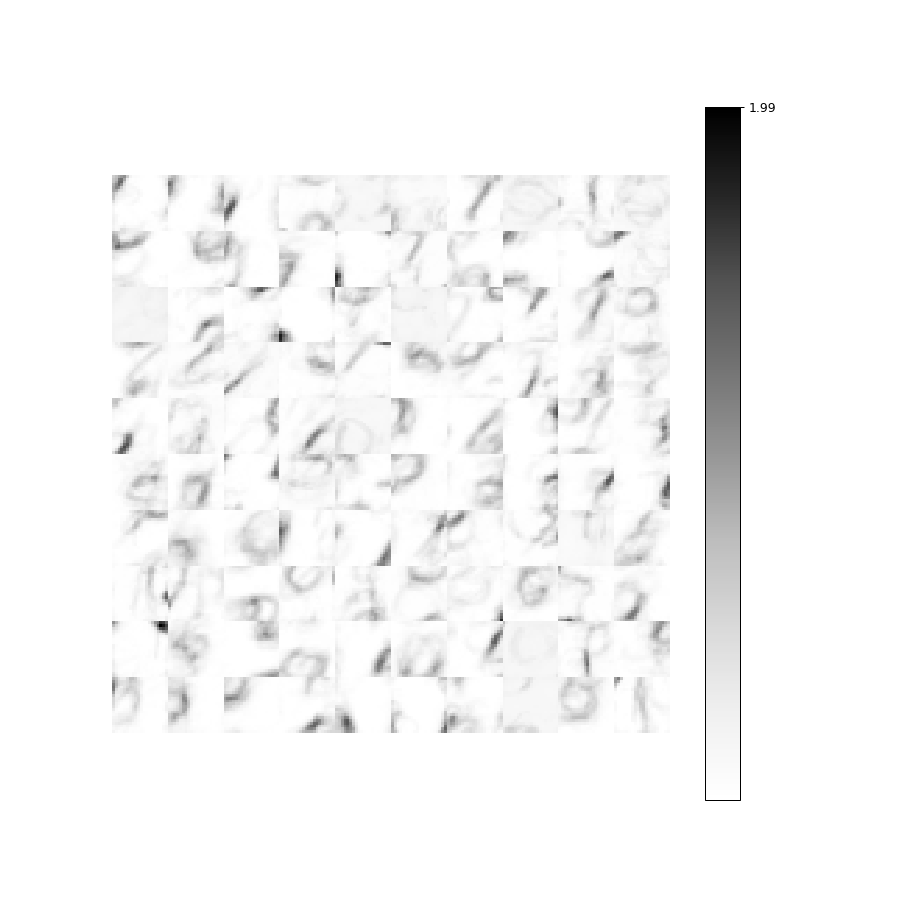

In [31]:
fig = plt.figure(figsize=(10, 10))

draw_weights((iw @ sw).get(), Ix, Iy, 20, fig)

Hmm.  The topology is much less evident in this one.  I'm going to increase `iex_coeff` and see what I can see.  Also the invariant prototypes started settling way more rapidly here, so I think it might do it some good to shake things up.

<IPython.core.display.Javascript object>


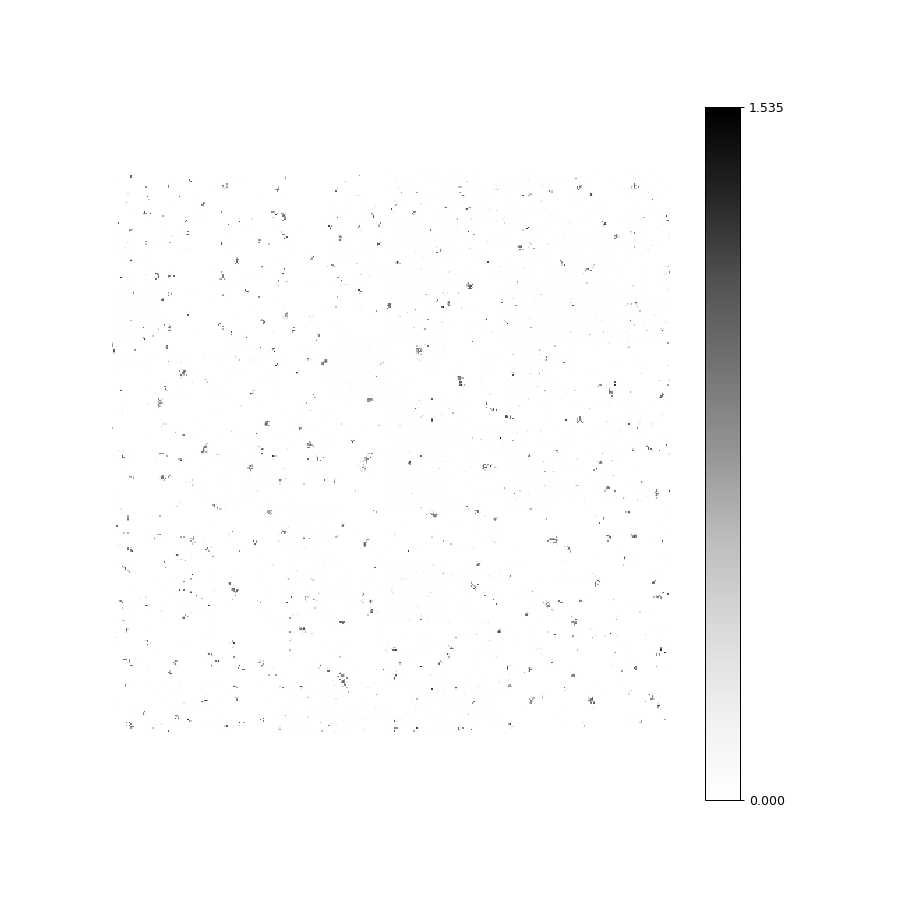

100%|██████████| 10000/10000 [00:13<00:00, 767.99it/s]


In [32]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10


# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy
iex = 2
iex_coeff = 1

i_lat_ex = gen_lat_ex(Ix, Iy, iex, iex_coeff)

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 2 / 6
leta = 0.08
seta = 0.0008

i_norm = sN / iN

for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_i = iw @ so
        io_i = i_lat_ex @ io_i # Lat ex
        
        winners = cp.argsort(io_i, axis=0)[-n_w:]
        mask = cp.zeros((iN, 1))
        mask[winners] = 1
        
        io_pert = mask * io_i
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = i_norm * (iw / cp.sum(iw, axis=1).reshape(-1, 1))

    if (ep // 4) % 2 == 0:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


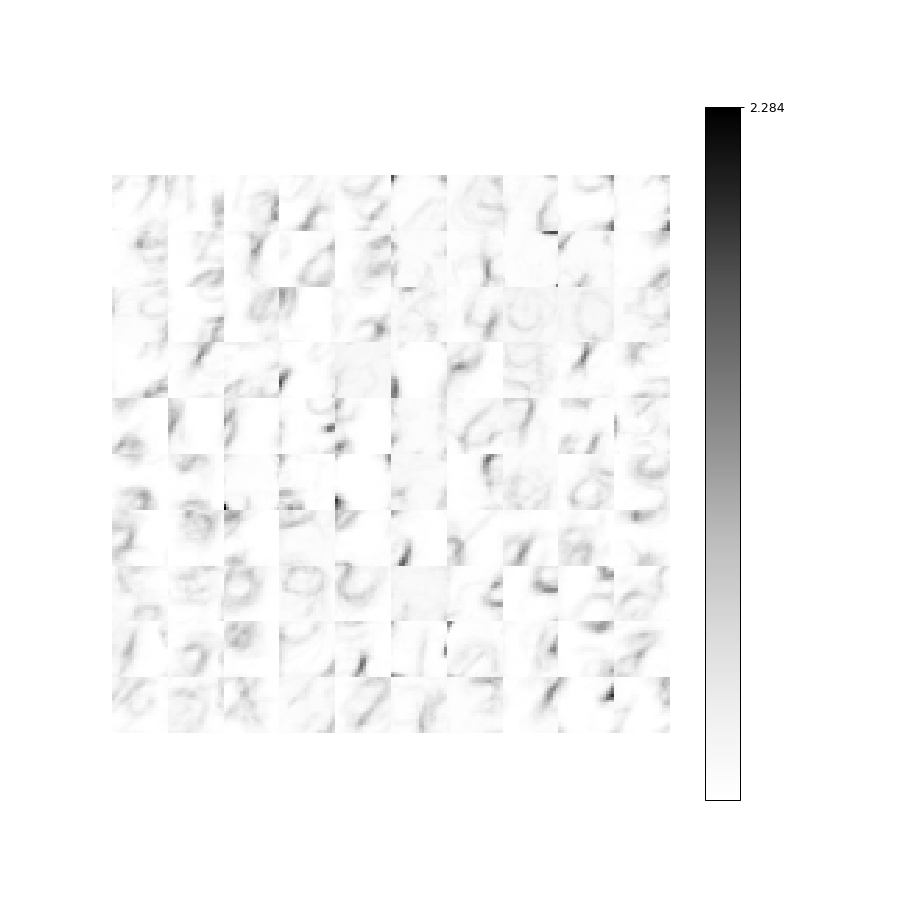

In [33]:
fig = plt.figure(figsize=(10, 10))

draw_weights((iw @ sw).get(), Ix, Iy, 20, fig)

Hmm.  Interesting.  Maybe there's a bit of topological organization, but it does not appear to be particularly strong.  Animation anyone?

<IPython.core.display.Javascript object>


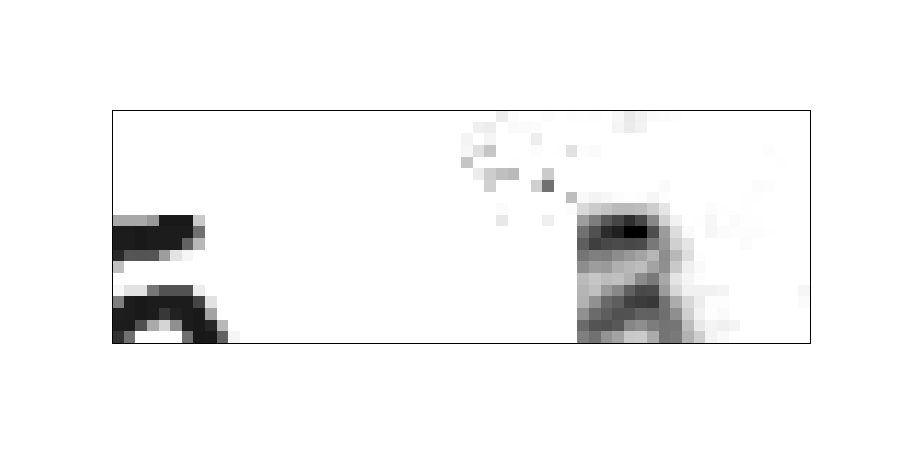

100%|██████████| 500/500 [00:01<00:00, 340.09it/s]


In [35]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()
lx_np = s_lat_ex.get()
ix_np = i_lat_ex.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    c = lx_np @ p
    winners = np.argsort(c, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_i = iw_np @ so
    io_i = ix_np @ io_i # Lat ex

    winners = np.argsort(io_i, axis=0)[-n_w:]
    mask = np.zeros((iN, 1))
    mask[winners] = 1

    io_pert = mask * io_i
    
    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((20, 60))
    
    glee = 10
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io.reshape(glee, glee)
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


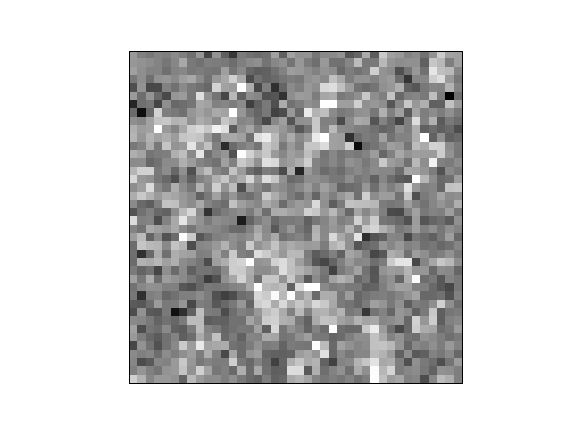

In [36]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(cp.sum(iw, axis=0).reshape(Kx, Ky).get(), cmap="gray_r")

Pretty darn good coverage.  Alright, I don't think there's much more to be learned here.

## Conclusions

Topographical connection are kinda eh in the invariant layer.  They maybe help organizing stuff a bit, but on the whole, not super useful.  Again, I'm not sure if topological organization is actually useful at all.  

It would be incredibly useful, however, to the brain.  Distance between different neurons is more important in the brain that in my networks.  So it'd be useful to have neurons next to each other that have some degree of correspondence.   

This is definitely something to keep in mind when I start putting my networks into custom hardware.  Everything will be a constraint then, so it's a good thing to keep in mind that topological connections can help organize the feature space.

## Next steps

I think I may have had some major intellectual breakthroughs just now (not related to this experiment), so I'm going to shut the p-instance down again, and then figure out what to do next.